# Introduction

### Problem Statement & Objective

Accurately predicting patient outcomes in critical care settings remains a significant challenge, often relying on subjective assessments and fragmented clinical data. Current systems do not consistently forecast long-term survival or the specific intensity of care required, leading to inefficient resource allocation and unequal treatment. This project addresses that gap by developing machine learning models to predict 180-day survival, care needs, and associated clinical patterns. <br>
<br>
By uncovering these predictive patterns, the project aims to help hospitals allocate resources more efficiently and support more personalized interventions tailored to each patient's unique clinical profile. This approach has the potential to improve both patient outcomes and system-wide operational effectiveness.<br>
<br>


### Dataset

The dataset used in this study is the SUPPORT2 dataset from the UCI Machine Learning Repository, comprising 9,105 patient records collected from ICU patients between 1994 and 1995. It includes 46 features spanning key categories such as demographics, vital signs, laboratory values, hospital characteristics, and two outcome variables: in-hospital death (hospdead) and mortality at any time (death). This dataset offers a comprehensive view of clinical factors relevant to patient outcomes in critical care settings.

link to data set: https://archive.ics.uci.edu/dataset/880/support2

---
---

# Code

#### imports

In [178]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,  roc_auc_score, RocCurveDisplay
from tensorflow.keras import backend as K
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import numpy as np
import xgboost as xgb
import plotly.express as px
from pathlib import Path

## EDA

#### retrieve the data

In [17]:
# fetch dataset support
data = fetch_ucirepo(id=880) 

# data (as pandas dataframes) 
X = data.data.features.copy()
y = data.data.targets.copy()

#### examining the X component

In [3]:
X.head(2)

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc
0,62.84998,male,Lung Cancer,Cancer,0,11.0,$11-$25k,0.0,9715.0,NaN,...,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,7.0
1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,$11-$25k,44.0,34496.0,NaN,...,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,1.0


In [7]:
# shape of X
X.shape

(9105, 42)

In [10]:
print(X.dtypes)

# summary statistics for numerical columns
print(X.describe())

# check for missing values
print(X.isnull().sum())

age         float64
sex          object
dzgroup      object
dzclass      object
num.co        int64
edu         float64
income       object
scoma       float64
charges     float64
totcst      float64
totmcst     float64
avtisst     float64
race         object
sps         float64
aps         float64
surv2m      float64
surv6m      float64
hday          int64
diabetes      int64
dementia      int64
ca           object
prg2m       float64
prg6m       float64
dnr          object
dnrday      float64
meanbp      float64
wblc        float64
hrt         float64
resp        float64
temp        float64
pafi        float64
alb         float64
bili        float64
crea        float64
sod         float64
ph          float64
glucose     float64
bun         float64
urine       float64
adlp        float64
adls        float64
adlsc       float64
dtype: object
               age       num.co          edu        scoma       charges  \
count  9105.000000  9105.000000  7471.000000  9104.000000  8.933000e+03

In [11]:
# getting numeric columns only

X_num = X.select_dtypes(include=['float64', 'int64'])
X_num.head(2)

,age,num.co,edu,scoma,charges,totcst,totmcst,avtisst,sps,aps,...,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc
0,62.84998,0,11.0,0.0,9715.0,NaN,NaN,7.0,33.898438,20.0,...,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,7.0
1,60.33899,2,12.0,44.0,34496.0,NaN,NaN,29.0,52.695312,74.0,...,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,1.0


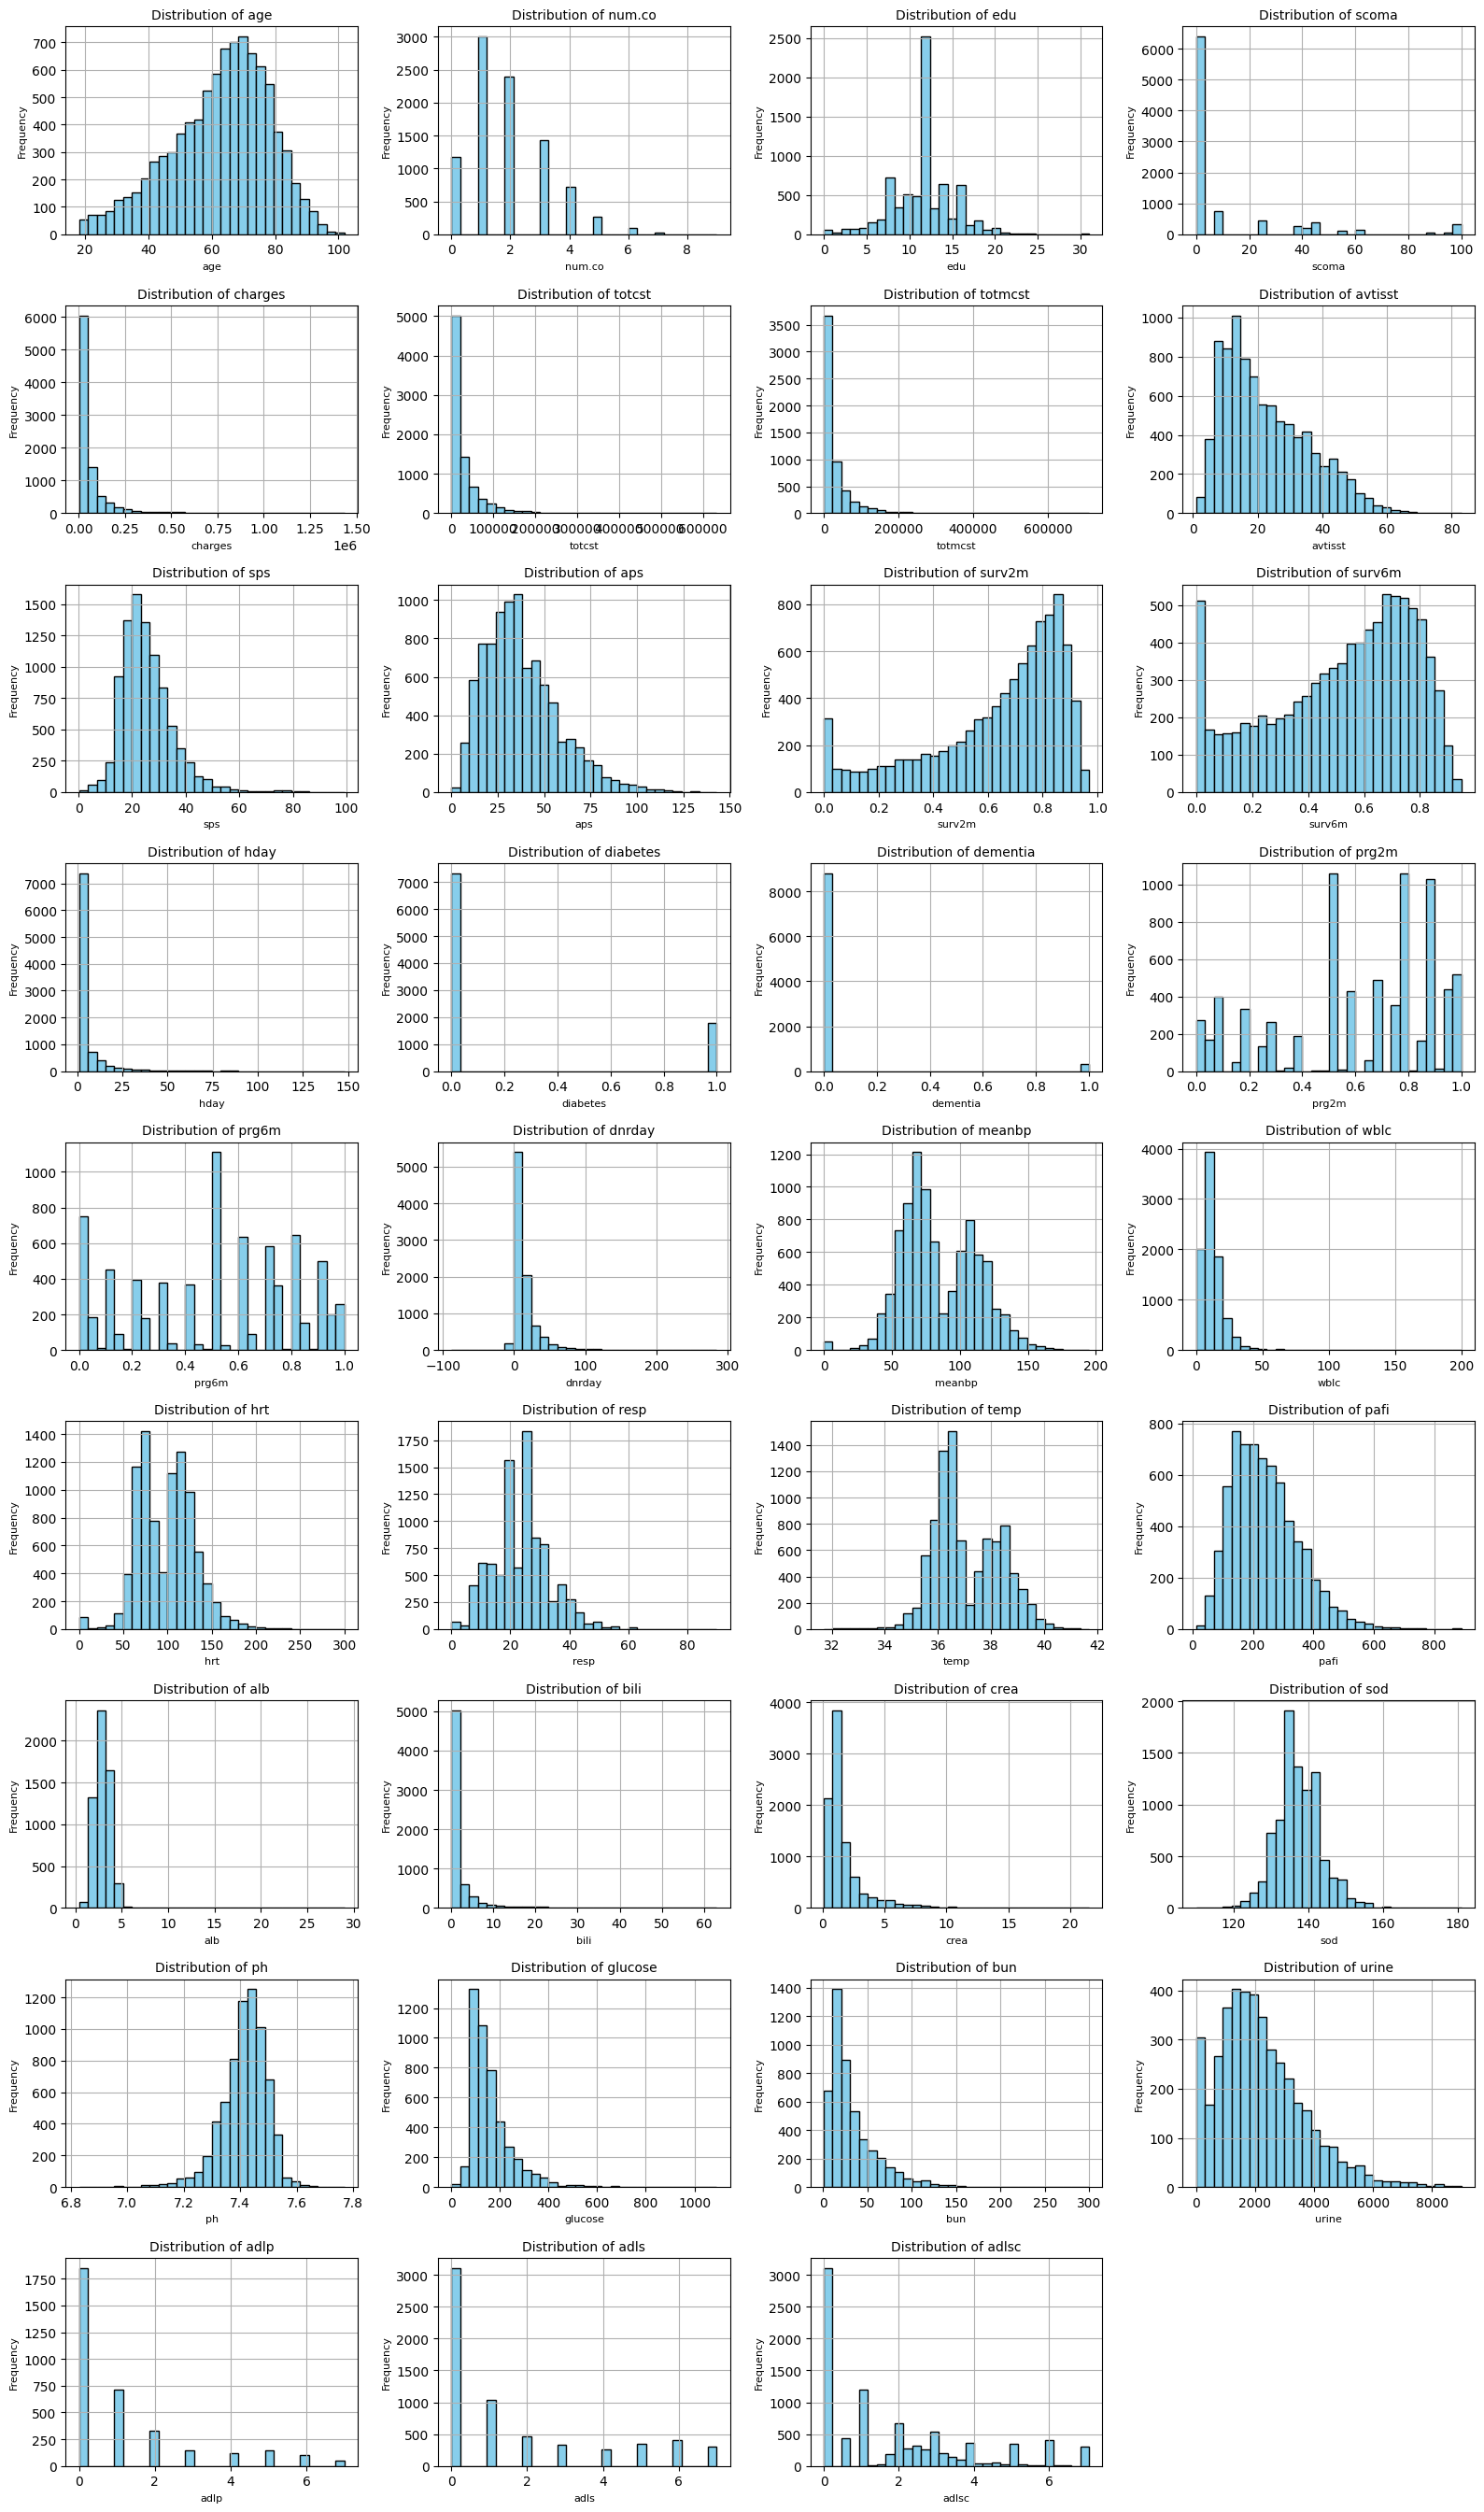

In [18]:
num_cols = len(X.select_dtypes(include='number').columns)
cols = 4  # number of columns in the grid
rows = math.ceil(num_cols / cols)  # calculate rows needed

fig = plt.figure(figsize=(cols * 4, rows * 3))

for i, column in enumerate(X.select_dtypes(include='number').columns, 1):
    ax = fig.add_subplot(rows, cols, i)
    X[column].hist(ax=ax, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {column}', fontsize=10)
    ax.set_xlabel(column, fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)

plt.tight_layout()
plt.show()

#### exploring the target variables

In [6]:
# shape of y
y.head(2)

,death,hospdead,sfdm2
0,0,0,NaN
1,1,1,<2 mo. follow-up


In [8]:
y.death.value_counts()

death
1    6201
0    2904
Name: count, dtype: int64

In [9]:
y.hospdead.value_counts()

hospdead
0    6745
1    2360
Name: count, dtype: int64

## Data Prep & Feature Engineering/Selection

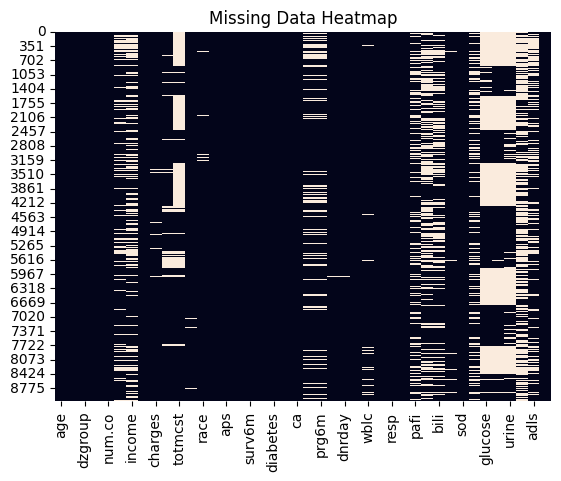

In [19]:
sns.heatmap(X.isnull(), cbar=False)
plt.title('Missing Data Heatmap')
plt.show()

#### Encoding categorical features

In [21]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Categorical columns based on dtype:", cat_cols)

# Check number of unique values per column
for col in cat_cols:
    unique_vals = X[col].nunique()
    print(f"{col}: {unique_vals} unique values")

Categorical columns based on dtype: ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'dnr']
sex: 2 unique values
dzgroup: 8 unique values
dzclass: 4 unique values
income: 4 unique values
race: 5 unique values
ca: 3 unique values
dnr: 3 unique values


Since the number of categories per categorical column is relatively low, we can encode these columns with one hot encoding. This will create a new column per unique category and designate it with a 0 or 1, 1 indicating that this record belongs to that category.

In [23]:
# Perform One-Hot encoding
X_encoded = pd.get_dummies(X, 
                           columns=cat_cols,
                           dtype=int,
                           drop_first=True
                           )

In [44]:
# verify there are all numeric feature types now
X_encoded.dtypes

age                           float64
num.co                          int64
edu                           float64
scoma                         float64
charges                       float64
totcst                        float64
totmcst                       float64
avtisst                       float64
sps                           float64
aps                           float64
surv2m                        float64
surv6m                        float64
hday                            int64
diabetes                        int64
dementia                        int64
prg2m                         float64
prg6m                         float64
dnrday                        float64
meanbp                        float64
wblc                          float64
hrt                           float64
resp                          float64
temp                          float64
pafi                          float64
alb                           float64
bili                          float64
crea        

#### correlation map

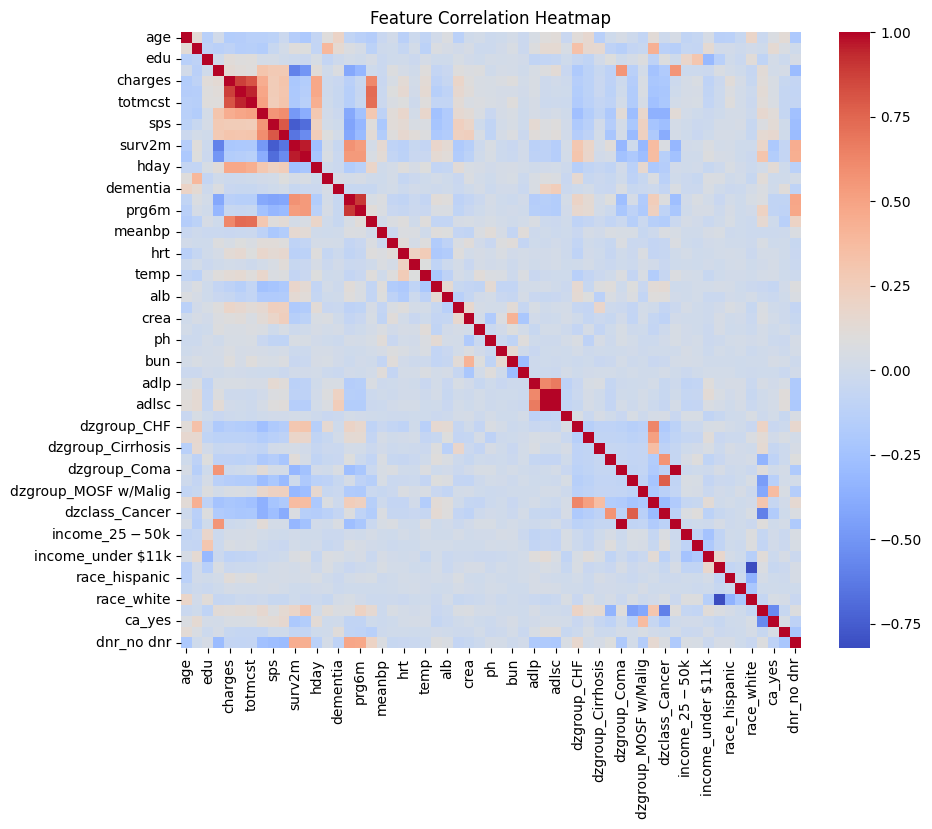

In [26]:
plt.figure(figsize=(10,8))
sns.heatmap(X_encoded.corr(), cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

#### Handling Missing Values

From the data's website there was some default values to fill na's for certain features

In [24]:
X_encoded['alb'] = X_encoded.alb.fillna(3.5)

X_encoded['pafi'] = X_encoded.pafi.fillna(333.3)

X_encoded['bili'] = X_encoded.bili.fillna(1.01)

X_encoded['crea'] = X_encoded.crea.fillna(1.01)

X_encoded['bun'] = X_encoded.bun.fillna(6.51)

X_encoded['wblc'] = X_encoded.wblc.fillna(9)

X_encoded['urine'] = X_encoded.urine.fillna(2502)

In [27]:
total_rows = X_encoded.shape[0]
remaining_rows = X_encoded.dropna().shape[0]
percent_remaining = (remaining_rows / total_rows) * 100

print(f"Rows remaining after dropping NaNs: {remaining_rows} of {total_rows} ({percent_remaining:.2f}%)")

Rows remaining after dropping NaNs: 751 of 9105 (8.25%)


Dropping any row that contained a NaN would wipe out over 90% of the data set. For that reason we will have to impute some of the data.

In [30]:
# Drop columns with more than 80% missing values
missing_threshold = 0.8
X_encoded_dropNA = X_encoded.loc[:, X_encoded.isnull().mean() < missing_threshold].copy()

In [31]:
X_encoded.shape

(9105, 57)

In [32]:
X_encoded_dropNA.shape

(9105, 57)

#### scaling the data

In [34]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_encoded_dropNA)

In [36]:
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X_encoded_dropNA.columns)

In [41]:
impute_knn = KNNImputer(n_neighbors=2)

In [42]:
X_imputed = impute_knn.fit_transform(X_scaled_df)

In [46]:
df_clean = pd.DataFrame(data=X_imputed, columns = X_scaled_df.columns)

#### assessing multicollinearity

In [47]:
# deal with multicolinearity

df_clean_const = add_constant(df_clean)

# Compute VIF
vif_df = pd.DataFrame()
vif_df["feature"] = df_clean_const.columns
vif_df["VIF"] = [variance_inflation_factor(df_clean_const.values, i) for i in range(df_clean_const.shape[1])]

/usr/local/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


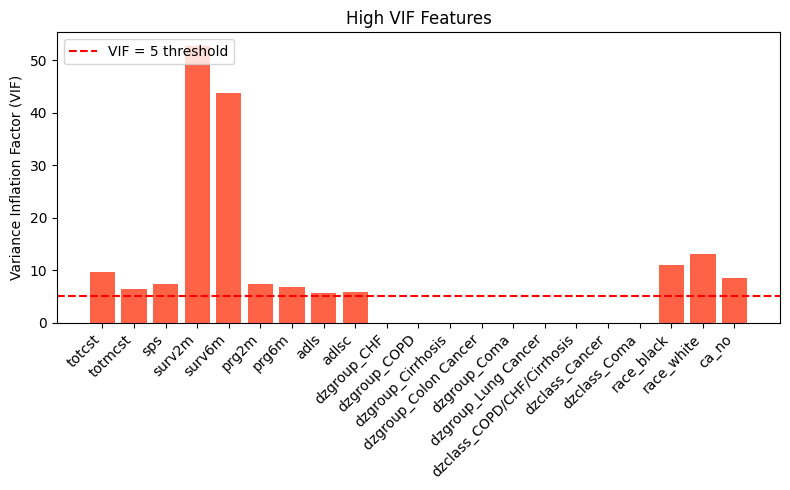

In [48]:
threshold = 5

# Filter the dataframe for VIF > threshold and exclude the constant/intercept if present
high_vif_df = vif_df[(vif_df['VIF'] > threshold) & (vif_df['feature'] != 'const')]

plt.figure(figsize=(8, 5))
plt.bar(high_vif_df['feature'], high_vif_df['VIF'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=threshold, color='red', linestyle='--', label=f'VIF = {threshold} threshold')
plt.ylabel('Variance Inflation Factor (VIF)')
plt.title('High VIF Features')
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
df_clean['death'] = y['death']
df_clean['hospdead'] = y['hospdead']

df_clean.to_parquet('data/cleaned_output_final_nb.parquet') 

In [72]:
X_final = df_clean.drop(columns=['death', 'hospdead']).copy()

#### feature correlation

In [55]:
correlation_matrix = df_clean.corr()

In [60]:
#correlation_matrix.death

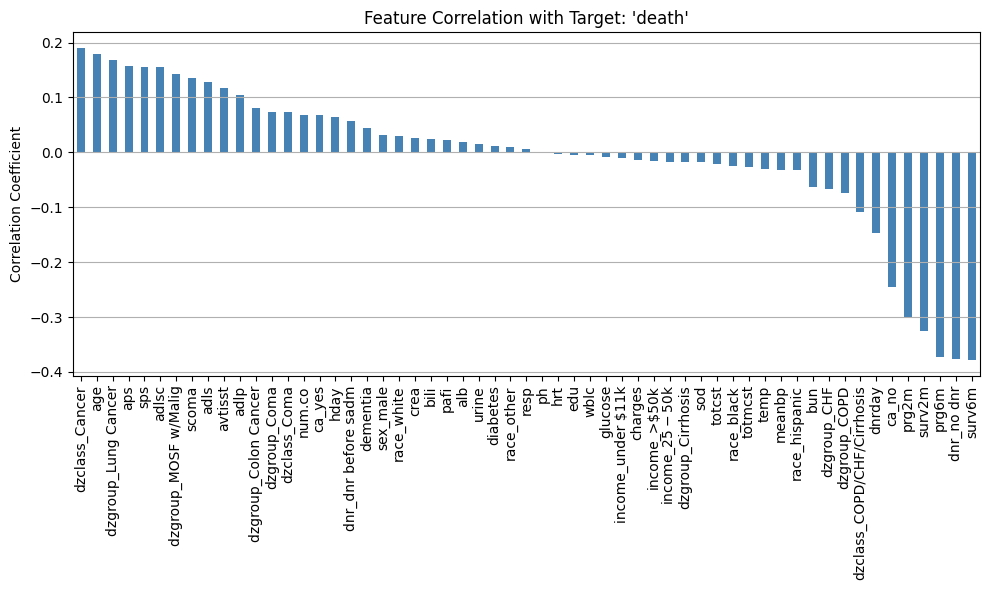

In [56]:
# Plot feature correlation with 'death' as a bar chart

target_corr_death = correlation_matrix['death'].drop(['death', 'hospdead']).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
target_corr_death.plot(kind='bar', color='steelblue')
plt.title("Feature Correlation with Target: 'death'")
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

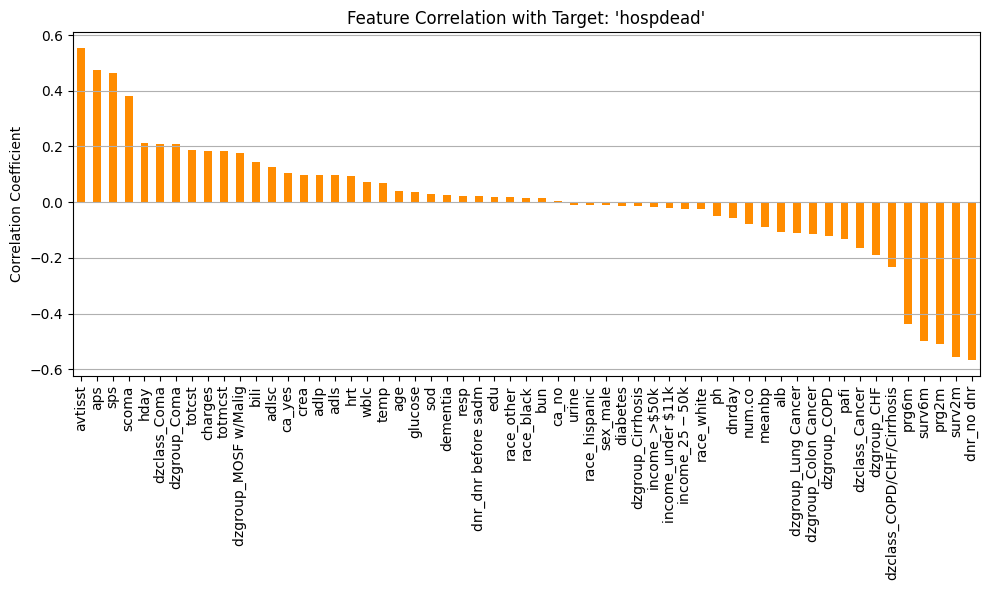

In [57]:
target_corr_hospdead = correlation_matrix['hospdead'].drop(['death', 'hospdead']).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
target_corr_hospdead.plot(kind='bar', color='darkorange')
plt.title("Feature Correlation with Target: 'hospdead'")
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### feature analysis with Random Forest

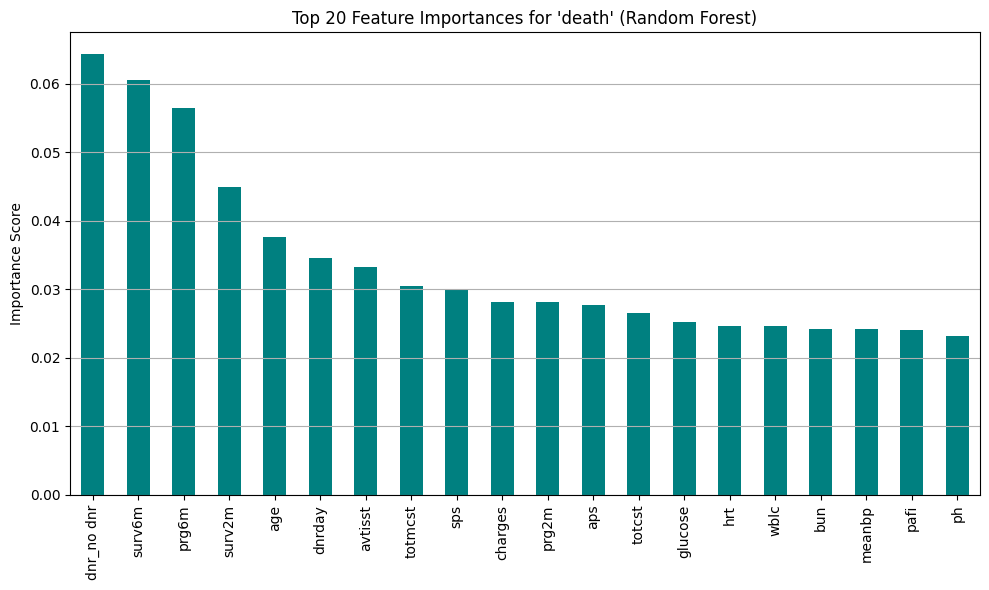

In [75]:


rf_model_death = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_death.fit(X_final, y.death)
feature_importances_death = pd.Series(rf_model_death.feature_importances_, index=X_final.columns)
feature_importances_death_sorted = feature_importances_death.sort_values(ascending=False)

# Visualize feature importance for 'death'
plt.figure(figsize=(10, 6))
feature_importances_death_sorted.head(20).plot(kind='bar', color='teal')
plt.title("Top 20 Feature Importances for 'death' (Random Forest)")
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
ax.set_aspect('auto')
plt.show()

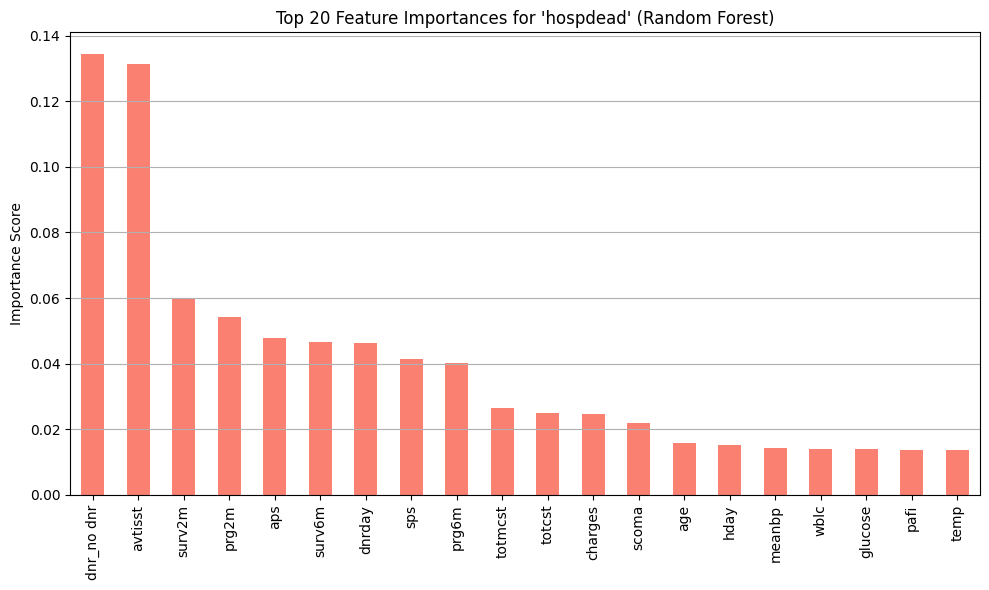

In [77]:
rf_model_hospdead = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_hospdead.fit(X_final, y.hospdead)
feature_importances_hospdead = pd.Series(rf_model_hospdead.feature_importances_, index=X_final.columns)
feature_importances_hospdead_sorted = feature_importances_hospdead.sort_values(ascending=False)

# Step 10: Visualize feature importance for 'hospdead'
plt.figure(figsize=(10, 6))
feature_importances_hospdead_sorted.head(20).plot(kind='bar', color='salmon')
plt.title("Top 20 Feature Importances for 'hospdead' (Random Forest)")
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
ax.set_aspect('auto')
plt.show()

#### analyzing the target variables

Class Distribution for 'death':
death
1    6201
0    2904
Name: count, dtype: int64


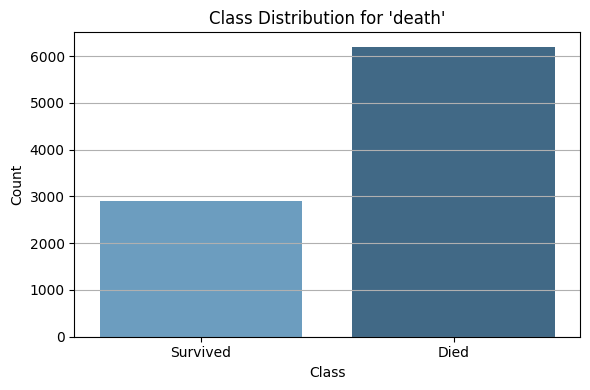

Class Distribution for 'hospdead':
hospdead
0    6745
1    2360
Name: count, dtype: int64


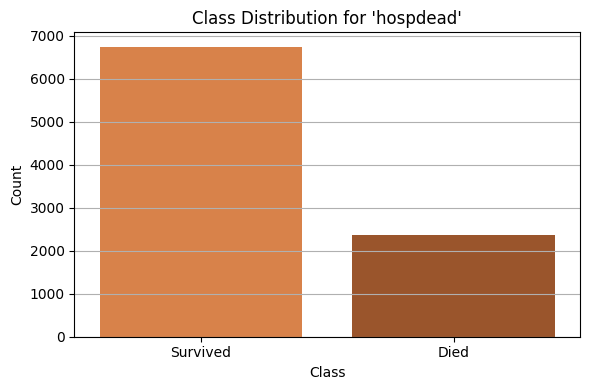

In [63]:
# Check the class distribution for 'death'

death_counts = df_clean['death'].value_counts()
print("Class Distribution for 'death':")
print(death_counts)

#Visualize the class distribution for 'death'

plt.figure(figsize=(6, 4))
sns.barplot(x=death_counts.index, 
            y=death_counts.values,
            hue=death_counts.index,
            palette='Blues_d',
            legend=False
           )
plt.title("Class Distribution for 'death'")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Survived', 'Died'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Check the class distribution for 'hospdead'

hospdead_counts = df_clean['hospdead'].value_counts()
print("Class Distribution for 'hospdead':")
print(hospdead_counts)

# Visualize the class distribution for 'hospdead'

plt.figure(figsize=(6, 4))
sns.barplot(x=hospdead_counts.index, 
            y=hospdead_counts.values,
            hue=hospdead_counts.index,
            palette='Oranges_d',
            legend=False
           )
plt.title("Class Distribution for 'hospdead'")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Survived', 'Died'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Due to the imbalance in the target data, we will balance the data set.

In [79]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imbalanced-learn]1/2 [imbalanced-learn]


In [80]:
from imblearn.over_sampling import SMOTE

In [82]:
# Apply SMOTE for 'death' target
smote = SMOTE(random_state=42)
X_smote_death, y_smote_death = smote.fit_resample(X_final, y.death)

print("After SMOTE - 'death':")
print(pd.Series(y_smote_death).value_counts())

# Apply SMOTE for 'hospdead' target
X_smote_hospdead, y_smote_hospdead = smote.fit_resample(X_final, y.hospdead)

print("After SMOTE - 'hospdead':")
print(pd.Series(y_smote_hospdead).value_counts())

After SMOTE - 'death':
death
0    6201
1    6201
Name: count, dtype: int64
After SMOTE - 'hospdead':
hospdead
0    6745
1    6745
Name: count, dtype: int64


In [83]:
# Combine features and target
X_smote_death_df = pd.DataFrame(X_smote_death, columns=X_final.columns)
X_smote_death_df['death'] = y_smote_death.values

# Save as Parquet
X_smote_death_df.to_parquet('data/Xy_smote_death_final_nb.parquet')
print("Saved Xy_smote_death.parquet successfully.")


# Save 'hospdead' balanced dataset


# Combine features and target
X_smote_hospdead_df = pd.DataFrame(X_smote_hospdead, columns=X_final.columns)
X_smote_hospdead_df['hospdead'] = y_smote_hospdead.values

# Save as Parquet
X_smote_hospdead_df.to_parquet('data/Xy_smote_hospdead_final_nb.parquet')
print("Saved Xy_smote_hospdead.parquet successfully.")



Saved Xy_smote_death.parquet successfully.
Saved Xy_smote_hospdead.parquet successfully.


## Modeling & Evaluation

#### splitting data

##### unbalanced data

In [132]:
# unbalanced data
val_split = 900 # how many records are being set aside for a validation set
max_range = len(df_clean) - 1
# generating a list of random integers to index out the validation set
val_indices = np.random.choice(max_range, size=val_split, replace=False)
# validation data
val_df = df_clean[df_clean.index.isin(val_indices)].copy()

# non validation data
non_val_df = df_clean[~df_clean.index.isin(val_indices)].copy()

In [133]:
len(val_df)

900

In [134]:
# Assuming df with features and two binary targets: 'death' and 'hospital_death'
X = non_val_df.drop(columns=['death', 'hospdead'])
y_death = non_val_df['death']
y_hosp_death = non_val_df['hospdead']

#####
X_val = val_df.drop(columns=['death', 'hospdead'])
y_val_death = val_df['death']
y_val_hosp_death = val_df['hospdead']


# Train/test split
X_train, X_test, y_train_death, y_test_death, y_train_hosp, y_test_hosp = train_test_split(
    X, y_death, y_hosp_death, test_size=0.2, stratify=y_death, random_state=42)

# the dataset has already been scaled so we won't be doing again

##### balanced data

For the balanced data, we are additionally going to only utilize the top 20 features for each data set.

In [199]:
top_features_death = ['dnr_no dnr', 'prg6m', 'surv6m', 'prg2m', 'dnrday', 
                      'surv2m', 'avtisst', 'age', 'sps', 'aps', 
                      'num.co', 'ca_no', 'charges', 'adlp', 'totmcst', 
                      'pafi', 'totcst', 'glucose', 'adlsc', 'alb', 'death']

top_features_hospdead = ['dnr_no dnr', 'avtisst', 'prg2m', 'surv2m', 'prg6m', 
                         'surv6m', 'dnrday', 'sps', 'aps', 'hday', 
                         'scoma', 'charges', 'totmcst', 'adlp', 'totcst', 
                         'alb', 'bili', 'age', 'pafi', 'glucose', 'hospdead']

In [200]:
# x smote death df
# validation data
val_X_smote_death_df = X_smote_death_df[X_smote_death_df.index.isin(val_indices)][top_features_death].copy()
#val_X_smote_death_df = X_val[top_features_death].copy()
# non validation data
non_val_X_smote_death_df = X_smote_death_df[~X_smote_death_df.index.isin(val_indices)][top_features_death].copy()

################

# x smote hospdeath df
val_X_smote_hospdead_df = X_smote_hospdead_df[X_smote_hospdead_df.index.isin(val_indices)].copy()
#val_X_smote_hospdead_df = X_val[top_features_hospdead].copy()
# non validation data
non_val_X_smote_hospdead_df = X_smote_hospdead_df[~X_smote_hospdead_df.index.isin(val_indices)].copy()

In [203]:
# Assuming df with features and two binary targets: 'death' and 'hospital_death'

X_death_bal = non_val_X_smote_death_df.drop(columns=['death'])
y_death_bal = non_val_X_smote_death_df['death']

# death validation set
X_death_val_bal = val_X_smote_death_df.drop(columns=['death'])
y_death_val_bal = val_X_smote_death_df['death']
#y_death_val_bal = y_hosp_death

X_hospdead_bal = non_val_X_smote_hospdead_df.drop(columns=['hospdead'])
y_hospdead_bal = non_val_X_smote_hospdead_df['hospdead']

# hospdead validation set
X_hospdead_val_bal = val_X_smote_hospdead_df.drop(columns=['hospdead'])
y_hospdead_val_bal = val_X_smote_hospdead_df['hospdead']
#y_hospdead_val_bal = y_val_hosp_death

# Step 3: Split datasets into training and testing sets
# Rationale: Evaluate model performance on unseen data to avoid overfitting.
# Stratified splitting preserves class balance.
X_train_death_bal, X_test_death_bal, y_train_death_bal, y_test_death_bal = train_test_split(
    X_death_bal, y_death_bal, test_size=0.2, random_state=42, stratify=y_death_bal
)
X_train_hospdead_bal, X_test_hospdead_bal, y_train_hospdead_bal, y_test_hospdead_bal = train_test_split(
    X_hospdead_bal, y_hospdead_bal, test_size=0.2, random_state=42, stratify=y_hospdead_bal
)

#### Neural Network

In [146]:
input_dim = X_train.shape[1]

inputs = Input(shape=(input_dim,))

# Shared hidden layers with dropout and L2
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)

# Output layers for each task
death_output = layers.Dense(1, activation='sigmoid', name='death')(x)
hospital_death_output = layers.Dense(1, activation='sigmoid', name='hospital_death')(x)

model = models.Model(inputs=inputs, outputs=[death_output, hospital_death_output])

model.compile(
    optimizer='adam',
    loss={
        'death': 'binary_crossentropy',
        'hospital_death': 'binary_crossentropy'
    },
    loss_weights={
        'death': 2.0,               # Prioritize 'death'
        'hospital_death': 1.0       # Less emphasis on 'hospital_death'
    },
    metrics={
        'death': 'AUC',
        'hospital_death': 'AUC'
    }
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      3,712 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ death (Dense)       │ (None, 1)         │         33 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hospital_death      │ (None, 1)         │         33 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,858 (22.88 KB)

 Trainable params: 5,858 (22.88 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
# adding callback 
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

In [184]:
X_train.head(2)

,age,num.co,edu,scoma,charges,totcst,totmcst,avtisst,sps,aps,...,income_>$50k,income_under $11k,race_black,race_hispanic,race_other,race_white,ca_no,ca_yes,dnr_dnr before sadm,dnr_no dnr
3030,1.697579,0.0,-1.00,1.0,-0.264118,-0.284989,-0.253833,0.330509,-0.339379,-0.269231,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
7416,-0.362608,2.0,-0.25,0.0,-0.321667,-0.344354,-0.290558,-0.279661,0.705267,0.653846,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
# training
history = model.fit(
    X_train,
    {'death': y_train_death, 'hospital_death': y_train_hosp},
    #validation_split=0.2,
    validation_data=(X_val,
                    [y_val_death,y_val_hosp_death]
                    ),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - death_AUC: 0.6239 - death_loss: 0.6635 - hospital_death_AUC: 0.6087 - hospital_death_loss: 0.6550 - loss: 2.0823 - val_death_AUC: 0.7768 - val_death_loss: 0.5301 - val_hospital_death_AUC: 0.9019 - val_hospital_death_loss: 0.3437 - val_loss: 1.4956 - learning_rate: 0.0010
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - death_AUC: 0.7680 - death_loss: 0.5342 - hospital_death_AUC: 0.8695 - hospital_death_loss: 0.3927 - loss: 1.5579 - val_death_AUC: 0.7968 - val_death_loss: 0.5135 - val_hospital_death_AUC: 0.9284 - val_hospital_death_loss: 0.3001 - val_loss: 1.4185 - learning_rate: 0.0010
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - death_AUC: 0.8038 - death_loss: 0.4886 - hospital_death_AUC: 0.8941 - hospital_death_loss: 0.3643 - loss: 1.4351 - val_death_AUC: 0.8155 - val_death_loss: 0.4928 - val_hospital_death_AUC: 0.9353 - val_hospital_death_loss: 0.2753 - val_loss: 1.3495 - learning_rate: 0.0010
Epoch 4/50
206/206 ━━━

In [150]:
eval_results = model.evaluate(X_test, {'death': y_test_death, 'hospital_death': y_test_hosp}, verbose=2)
print(f"Test Loss and AUC: {eval_results}")

52/52 - 1s - 10ms/step - death_AUC: 0.8524 - death_loss: 0.4325 - hospital_death_AUC: 0.9370 - hospital_death_loss: 0.2723 - loss: 1.2108
Test Loss and AUC: [1.2107726335525513, 0.4324919879436493, 0.2722811996936798, 0.8523983359336853, 0.9369807243347168]


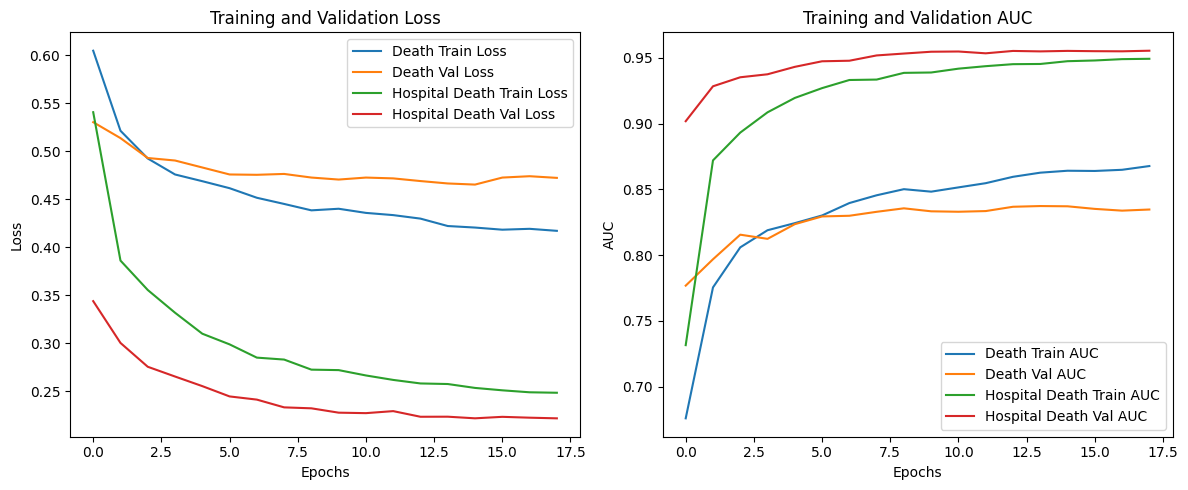

In [151]:
# history is the object returned by model.fit()
history_dict = history.history

# Plot training & validation loss for both tasks
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['death_loss'], label='Death Train Loss')
plt.plot(history_dict['val_death_loss'], label='Death Val Loss')
plt.plot(history_dict['hospital_death_loss'], label='Hospital Death Train Loss')
plt.plot(history_dict['val_hospital_death_loss'], label='Hospital Death Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# AUC plot (if you tracked it)
plt.subplot(1, 2, 2)
plt.plot(history_dict['death_AUC'], label='Death Train AUC')
plt.plot(history_dict['val_death_AUC'], label='Death Val AUC')
plt.plot(history_dict['hospital_death_AUC'], label='Hospital Death Train AUC')
plt.plot(history_dict['val_hospital_death_AUC'], label='Hospital Death Val AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [190]:
val_eval_results = model.evaluate(X_val, {'death': y_val_death, 'hospital_death': y_val_hosp_death}, verbose=2)
print(f"Validation Loss and AUC: {val_eval_results}")

29/29 - 0s - 5ms/step - death_AUC: 0.8371 - death_loss: 0.4651 - hospital_death_AUC: 0.9554 - hospital_death_loss: 0.2216 - loss: 1.2163
Validation Loss and AUC: [1.2162904739379883, 0.465116947889328, 0.22156694531440735, 0.8371395468711853, 0.9553643465042114]


#### Random Forest

Random Forest Classifier on 'death' (Test Data):
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1180
           1       0.87      0.78      0.83      1121

    accuracy                           0.84      2301
   macro avg       0.84      0.84      0.84      2301
weighted avg       0.84      0.84      0.84      2301

Confusion Matrix:
[[1053  127]
 [ 244  877]]
Test accurcay score:  0.8387657540199913

Random Forest Classifier on 'death' (Validation Data):
              precision    recall  f1-score   support

           0       0.63      0.73      0.67       303
           1       0.85      0.78      0.82       597

    accuracy                           0.76       900
   macro avg       0.74      0.75      0.75       900
weighted avg       0.78      0.76      0.77       900

Confusion Matrix (Validation):
[[220  83]
 [129 468]]
Validation accurcay score:  0.7644444444444445


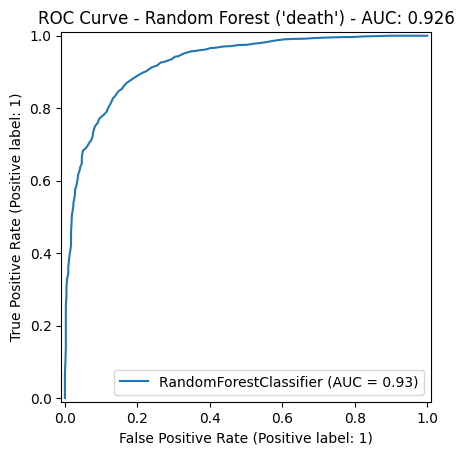

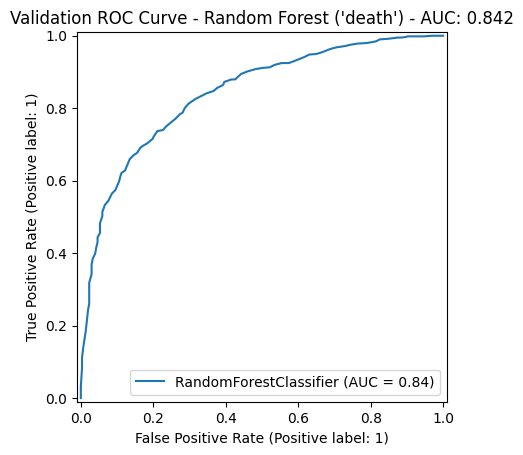

In [204]:
rf_death = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_death.fit(X_train_death_bal, y_train_death_bal)

# Step 5: Evaluate RandomForestClassifier on 'death' test set
# Rationale: Assess the model’s generalization performance using standard metrics.
y_pred_death = rf_death.predict(X_test_death_bal)

print("Random Forest Classifier on 'death' (Test Data):")
print(classification_report(y_test_death_bal, y_pred_death))
print("Confusion Matrix:")
print(confusion_matrix(y_test_death_bal, y_pred_death))
print("Test accurcay score: ", accuracy_score(y_test_death_bal, y_pred_death))
print('')
print("Random Forest Classifier on 'death' (Validation Data):")

y_pred_death_val = rf_death.predict(X_death_val_bal)
print(classification_report(y_death_val_bal, y_pred_death_val))
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_death_val_bal, y_pred_death_val))
print("Validation accurcay score: ", accuracy_score(y_death_val_bal, y_pred_death_val))

# Calculate and plot ROC Curve
roc_auc_death = roc_auc_score(y_test_death_bal, rf_death.predict_proba(X_test_death_bal)[:, 1])
RocCurveDisplay.from_estimator(rf_death, X_test_death_bal, y_test_death_bal)
plt.title(f"ROC Curve - Random Forest ('death') - AUC: {roc_auc_death:.3f}")
plt.show()

# validation ROC curve
roc_auc_death_val = roc_auc_score(y_death_val_bal, rf_death.predict_proba(X_death_val_bal)[:, 1])
RocCurveDisplay.from_estimator(rf_death, X_death_val_bal, y_death_val_bal)
plt.title(f"Validation ROC Curve - Random Forest ('death') - AUC: {roc_auc_death_val:.3f}")
plt.show()


Random Forest Classifier on 'hospdead' (Test Data):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1213
           1       0.94      0.93      0.94      1305

    accuracy                           0.93      2518
   macro avg       0.93      0.93      0.93      2518
weighted avg       0.93      0.93      0.93      2518

Confusion Matrix:
[[1133   80]
 [  85 1220]]
Test accurcay score:  0.9344718030182685


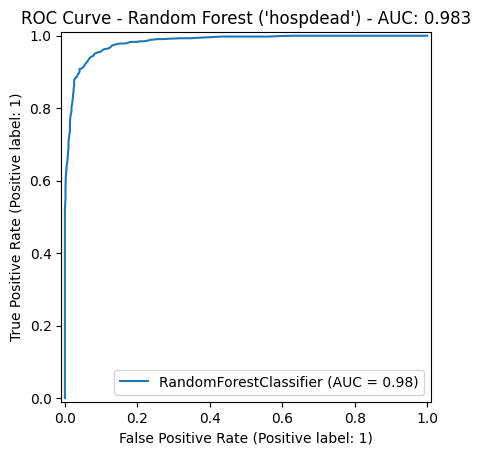

In [205]:
# Step 6: Train RandomForestClassifier on 'hospdead' target
# Rationale: Repeat the process for the second target variable.
rf_hospdead = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_hospdead.fit(X_train_hospdead_bal, y_train_hospdead_bal)

# Step 7: Evaluate RandomForestClassifier on 'hospdead' test set
y_pred_hospdead = rf_hospdead.predict(X_test_hospdead_bal)

print("Random Forest Classifier on 'hospdead' (Test Data):")
print(classification_report(y_test_hospdead_bal, y_pred_hospdead))
print("Confusion Matrix:")
print(confusion_matrix(y_test_hospdead_bal, y_pred_hospdead))
print("Test accurcay score: ", accuracy_score(y_test_hospdead_bal, y_pred_hospdead))

# Calculate and plot ROC Curve
roc_auc_hospdead = roc_auc_score(y_test_hospdead_bal, rf_hospdead.predict_proba(X_test_hospdead_bal)[:, 1])
RocCurveDisplay.from_estimator(rf_hospdead, X_test_hospdead_bal, y_test_hospdead_bal)
plt.title(f"ROC Curve - Random Forest ('hospdead') - AUC: {roc_auc_hospdead:.3f}")
plt.show()

Random Forest Classifier on 'hospdead' (Validation Data):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       680
           1       0.82      0.88      0.85       220

    accuracy                           0.92       900
   macro avg       0.89      0.91      0.90       900
weighted avg       0.93      0.92      0.93       900

Confusion Matrix:
[[639  41]
 [ 27 193]]
Validation accuracy score:  0.9244444444444444


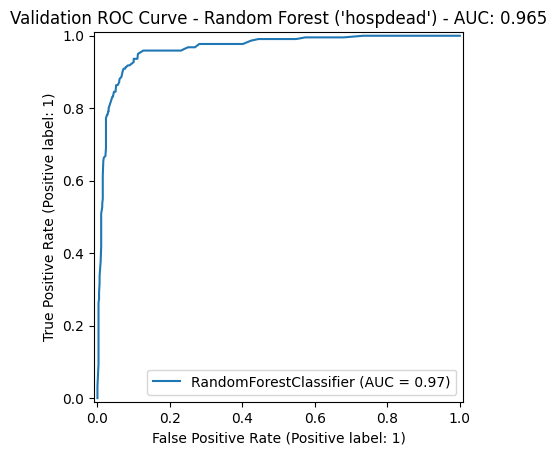

In [206]:
# Step 7: Evaluate RandomForestClassifier on 'hospdead' test set
y_pred_hospdead_val = rf_hospdead.predict(X_hospdead_val_bal)

print("Random Forest Classifier on 'hospdead' (Validation Data):")
print(classification_report(y_hospdead_val_bal, y_pred_hospdead_val))
print("Confusion Matrix:")
print(confusion_matrix(y_hospdead_val_bal, y_pred_hospdead_val))
print("Validation accuracy score: ", accuracy_score(y_hospdead_val_bal, y_pred_hospdead_val))

# Calculate and plot ROC Curve
roc_auc_hospdead = roc_auc_score(y_hospdead_val_bal, rf_hospdead.predict_proba(X_hospdead_val_bal)[:, 1])
RocCurveDisplay.from_estimator(rf_hospdead, X_hospdead_val_bal, y_hospdead_val_bal)
plt.title(f"Validation ROC Curve - Random Forest ('hospdead') - AUC: {roc_auc_hospdead:.3f}")
plt.show()

#### Logistic Regression

Logistic Regression on 'death' (Test Data) - Top Features:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1180
           1       0.79      0.72      0.75      1121

    accuracy                           0.77      2301
   macro avg       0.77      0.77      0.77      2301
weighted avg       0.77      0.77      0.77      2301

Confusion Matrix:
[[966 214]
 [317 804]]


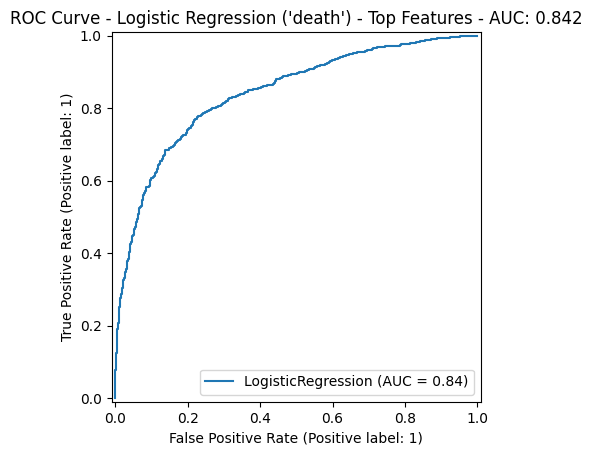

              precision    recall  f1-score   support

           0       0.59      0.76      0.66       303
           1       0.85      0.73      0.79       597

    accuracy                           0.74       900
   macro avg       0.72      0.74      0.72       900
weighted avg       0.76      0.74      0.74       900

Confusion Matrix (Validation):
[[229  74]
 [162 435]]
Validation accurcay score:  0.7377777777777778


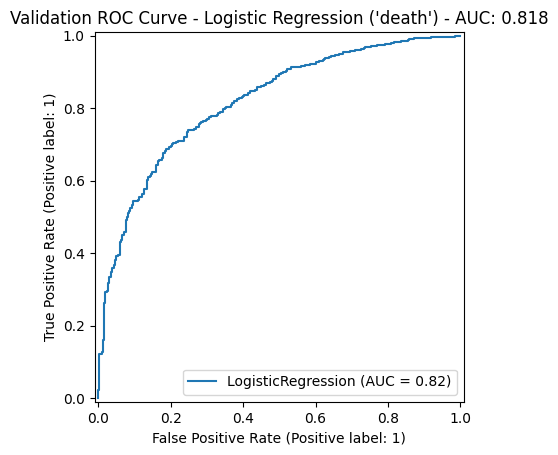

In [207]:
# Step 5: Train Logistic Regression on 'death' target
# Rationale: Logistic Regression provides interpretable odds ratios and handles class imbalance with 'balanced' class weight.
lr_death = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='liblinear'  # robust for smaller datasets
)
lr_death.fit(X_train_death_bal, y_train_death_bal)

# Step 6: Evaluate Logistic Regression on 'death' test set
y_pred_death = lr_death.predict(X_test_death_bal)

print("Logistic Regression on 'death' (Test Data) - Top Features:")
print(classification_report(y_test_death_bal, y_pred_death))
print("Confusion Matrix:")
print(confusion_matrix(y_test_death_bal, y_pred_death))
# ROC Curve
roc_auc_death = roc_auc_score(y_test_death_bal, lr_death.predict_proba(X_test_death_bal)[:, 1])
RocCurveDisplay.from_estimator(lr_death, X_test_death_bal, y_test_death_bal)
plt.title(f"ROC Curve - Logistic Regression ('death') - Top Features - AUC: {roc_auc_death:.3f}")
plt.show()


y_pred_death_val = lr_death.predict(X_death_val_bal)
print(classification_report(y_death_val_bal, y_pred_death_val))
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_death_val_bal, y_pred_death_val))
print("Validation accurcay score: ", accuracy_score(y_death_val_bal, y_pred_death_val))

# validation ROC curve
roc_auc_death_val = roc_auc_score(y_death_val_bal, lr_death.predict_proba(X_death_val_bal)[:, 1])
RocCurveDisplay.from_estimator(lr_death, X_death_val_bal, y_death_val_bal)
plt.title(f"Validation ROC Curve - Logistic Regression ('death') - AUC: {roc_auc_death_val:.3f}")
plt.show()


Logistic Regression on 'hospdead' (Test Data) - Top Features:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1213
           1       0.90      0.88      0.89      1305

    accuracy                           0.89      2518
   macro avg       0.89      0.89      0.89      2518
weighted avg       0.89      0.89      0.89      2518

Confusion Matrix:
[[1089  124]
 [ 152 1153]]


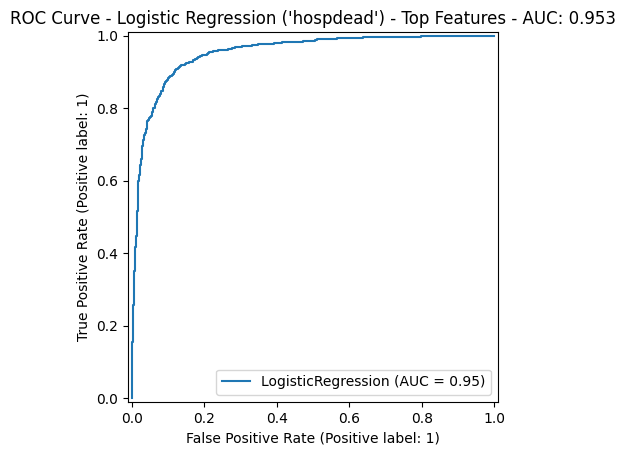


Random Forest Classifier on 'hospdead' (Validation Data):
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       680
           1       0.73      0.85      0.79       220

    accuracy                           0.89       900
   macro avg       0.84      0.88      0.85       900
weighted avg       0.90      0.89      0.89       900

Confusion Matrix:
[[610  70]
 [ 32 188]]
Validation accuracy score:  0.8866666666666667



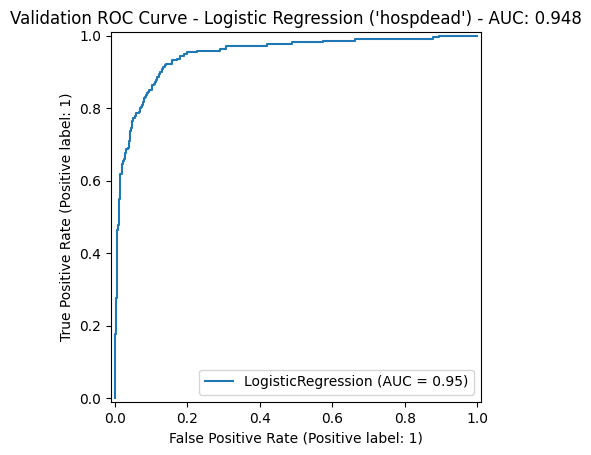

In [208]:
# Step 7: Train Logistic Regression on 'hospdead' target
lr_hospdead = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='liblinear'
)
lr_hospdead.fit(X_train_hospdead_bal, y_train_hospdead_bal)

# Step 8: Evaluate Logistic Regression on 'hospdead' test set
y_pred_hospdead = lr_hospdead.predict(X_test_hospdead_bal)

print("Logistic Regression on 'hospdead' (Test Data) - Top Features:")
print(classification_report(y_test_hospdead_bal, y_pred_hospdead))
print("Confusion Matrix:")
print(confusion_matrix(y_test_hospdead_bal, y_pred_hospdead))
roc_auc_hospdead = roc_auc_score(y_test_hospdead_bal, lr_hospdead.predict_proba(X_test_hospdead_bal)[:, 1])
RocCurveDisplay.from_estimator(lr_hospdead, X_test_hospdead_bal, y_test_hospdead_bal)
plt.title(f"ROC Curve - Logistic Regression ('hospdead') - Top Features - AUC: {roc_auc_hospdead:.3f}")
plt.show()
print('')
## validation set
y_pred_hospdead_val = lr_hospdead.predict(X_hospdead_val_bal)

print("Random Forest Classifier on 'hospdead' (Validation Data):")
print(classification_report(y_hospdead_val_bal, y_pred_hospdead_val))
print("Confusion Matrix:")
print(confusion_matrix(y_hospdead_val_bal, y_pred_hospdead_val))
print("Validation accuracy score: ", accuracy_score(y_hospdead_val_bal, y_pred_hospdead_val))
print('')

# Calculate and plot ROC Curve
roc_auc_hospdead = roc_auc_score(y_hospdead_val_bal, lr_hospdead.predict_proba(X_hospdead_val_bal)[:, 1])
RocCurveDisplay.from_estimator(lr_hospdead, X_hospdead_val_bal, y_hospdead_val_bal)
plt.title(f"Validation ROC Curve - Logistic Regression ('hospdead') - AUC: {roc_auc_hospdead:.3f}")
plt.show()


#### XGBoost

/usr/local/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:30:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier on 'death' (Test Data) - Top Features:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1180
           1       0.84      0.83      0.84      1121

    accuracy                           0.84      2301
   macro avg       0.84      0.84      0.84      2301
weighted avg       0.84      0.84      0.84      2301

Confusion Matrix:
[[1008  172]
 [ 191  930]]


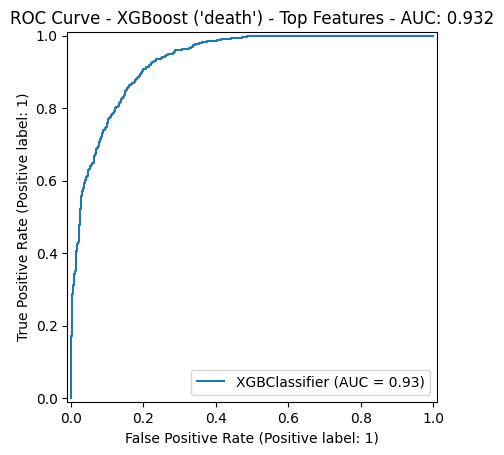

In [209]:
xgb_death = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=1,
    use_label_encoder=False,
    random_state=42
)
xgb_death.fit(X_train_death_bal, y_train_death_bal)

# Step 7: Evaluate XGBoost Classifier on 'death' test set
y_pred_death = xgb_death.predict(X_test_death_bal)
print("XGBoost Classifier on 'death' (Test Data) - Top Features:")
print(classification_report(y_test_death_bal, y_pred_death))
print("Confusion Matrix:")
print(confusion_matrix(y_test_death_bal, y_pred_death))

# Plot ROC Curve for 'death'
roc_auc_death = roc_auc_score(y_test_death_bal, xgb_death.predict_proba(X_test_death_bal)[:, 1])
RocCurveDisplay.from_estimator(xgb_death, X_test_death_bal, y_test_death_bal)
plt.title(f"ROC Curve - XGBoost ('death') - Top Features - AUC: {roc_auc_death:.3f}")
plt.show()

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       303
           1       0.81      0.84      0.83       597

    accuracy                           0.77       900
   macro avg       0.74      0.73      0.73       900
weighted avg       0.76      0.77      0.76       900

Confusion Matrix (Validation):
[[188 115]
 [ 96 501]]
Validation accurcay score:  0.7655555555555555


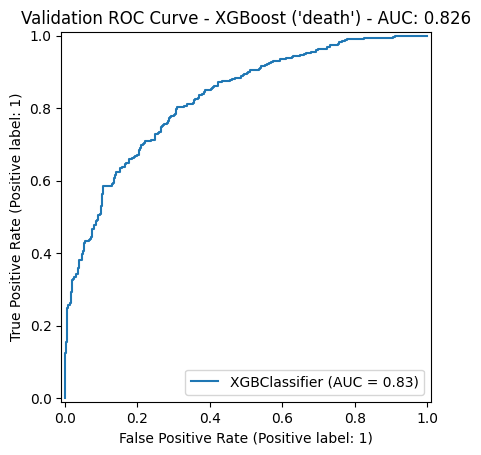

In [210]:
y_pred_death_val = xgb_death.predict(X_death_val_bal)
print(classification_report(y_death_val_bal, y_pred_death_val))
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_death_val_bal, y_pred_death_val))
print("Validation accurcay score: ", accuracy_score(y_death_val_bal, y_pred_death_val))
# validation ROC curve
roc_auc_death_val = roc_auc_score(y_death_val_bal, xgb_death.predict_proba(X_death_val_bal)[:, 1])
RocCurveDisplay.from_estimator(xgb_death, X_death_val_bal, y_death_val_bal)
plt.title(f"Validation ROC Curve - XGBoost ('death') - AUC: {roc_auc_death_val:.3f}")
plt.show()

/usr/local/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:30:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classifier on 'hospdead' (Test Data) - Top Features:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1213
           1       0.95      0.93      0.94      1305

    accuracy                           0.94      2518
   macro avg       0.94      0.94      0.94      2518
weighted avg       0.94      0.94      0.94      2518

Confusion Matrix:
[[1148   65]
 [  91 1214]]


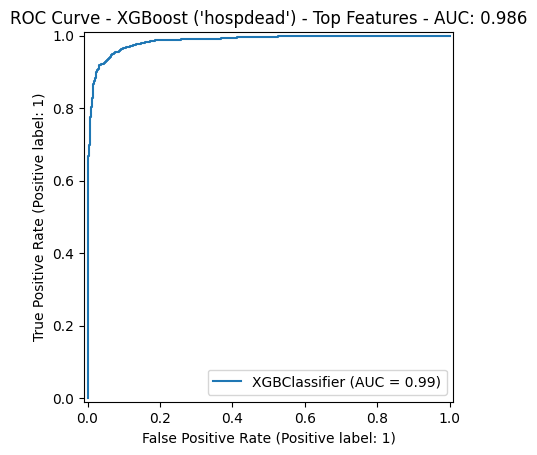

In [211]:
# Step 8: Initialize and train XGBoost Classifier for 'hospdead'
xgb_hospdead = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=1,
    use_label_encoder=False,
    random_state=42
)
xgb_hospdead.fit(X_train_hospdead_bal, y_train_hospdead_bal)

# Step 9: Evaluate XGBoost Classifier on 'hospdead' test set
y_pred_hospdead = xgb_hospdead.predict(X_test_hospdead_bal)
print("\nXGBoost Classifier on 'hospdead' (Test Data) - Top Features:")
print(classification_report(y_test_hospdead_bal, y_pred_hospdead))
print("Confusion Matrix:")
print(confusion_matrix(y_test_hospdead_bal, y_pred_hospdead))

# Plot ROC Curve for 'hospdead'
roc_auc_hospdead = roc_auc_score(y_test_hospdead_bal, xgb_hospdead.predict_proba(X_test_hospdead_bal)[:, 1])
RocCurveDisplay.from_estimator(xgb_hospdead, X_test_hospdead_bal, y_test_hospdead_bal)
plt.title(f"ROC Curve - XGBoost ('hospdead') - Top Features - AUC: {roc_auc_hospdead:.3f}")
plt.show()

XGBoost on 'hospdead' (Validation Data):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       680
           1       0.84      0.86      0.85       220

    accuracy                           0.93       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.93      0.93      0.93       900

Confusion Matrix:
[[644  36]
 [ 31 189]]
Validation accuracy score:  0.9255555555555556



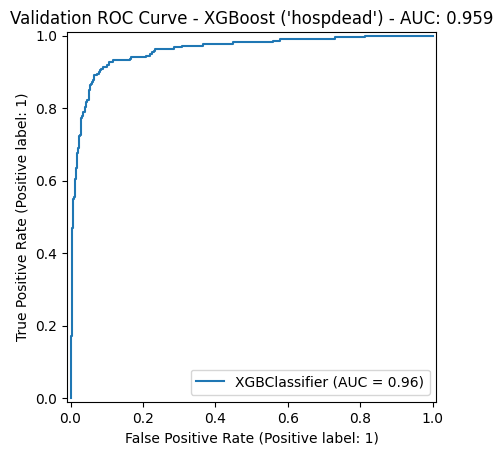

In [212]:
## validation set
y_pred_hospdead_val = xgb_hospdead.predict(X_hospdead_val_bal)

print("XGBoost on 'hospdead' (Validation Data):")
print(classification_report(y_hospdead_val_bal, y_pred_hospdead_val))
print("Confusion Matrix:")
print(confusion_matrix(y_hospdead_val_bal, y_pred_hospdead_val))
print("Validation accuracy score: ", accuracy_score(y_hospdead_val_bal, y_pred_hospdead_val))
print('')
# Calculate and plot ROC Curve
roc_auc_hospdead = roc_auc_score(y_hospdead_val_bal, xgb_hospdead.predict_proba(X_hospdead_val_bal)[:, 1])
RocCurveDisplay.from_estimator(xgb_hospdead, X_hospdead_val_bal, y_hospdead_val_bal)
plt.title(f"Validation ROC Curve - XGBoost ('hospdead') - AUC: {roc_auc_hospdead:.3f}")
plt.show()

## Evaluation

In [221]:
## validation AUC

### no feature pruning
val_death_auc = {
    'neural net':0.8371,
    'random forest': 0.86,
    'logistic regression': 0.831,
    'XGBoost': 0.838
}

val_hospdead_auc = {
    'neural net': 0.9554,
    'random forest': 0.965,
    'logistic regression':0.948,
    'XGBoost': 0.959
}

In [222]:
val_death_auc_df = pd.DataFrame(val_death_auc.items(), columns = ['model', 'AUC'])
val_hospdead_auc_df = pd.DataFrame(val_hospdead_auc.items(), columns = ['model', 'AUC'])

In [265]:
color_map = {
    'random forest': '#2ca02c',
    'XGBoost': '#ff7f0e',
    'neural net': '#1f77b4',
    'logistic regression': '#d62728'
}

In [283]:
plot_folder = Path.cwd() / 'plots'

In [284]:
plot_folder.mkdir()

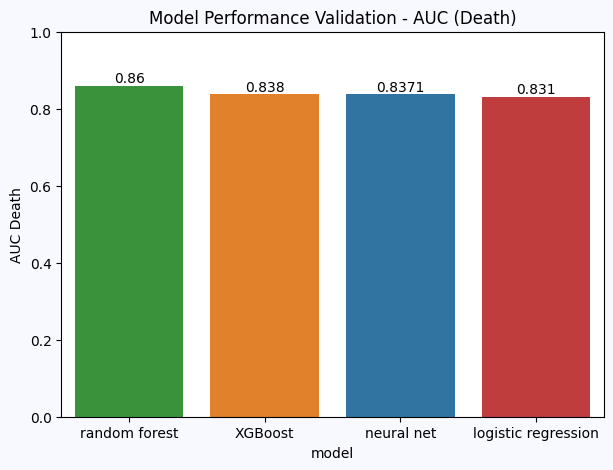

In [285]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(val_death_auc_df,
            x='model',
            y='AUC',
            hue = 'model',
            ax=ax,
            order=val_death_auc_df.sort_values(by='AUC',ascending=False).model,
            palette=color_map
            #hue_order=val_death_auc_df.sort_values(by='AUC',ascending=False).model
            )
title = 'Model Performance Validation - AUC (Death)'
plt.title(title)
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)
ax.set_ylabel('AUC Death')
plt.ylim(0,1)
fig.set_facecolor('ghostwhite')
ax.set_aspect('auto')
file_path = plot_folder / title
plt.savefig(str(file_path)+'.png', dpi=1000, bbox_inches='tight')

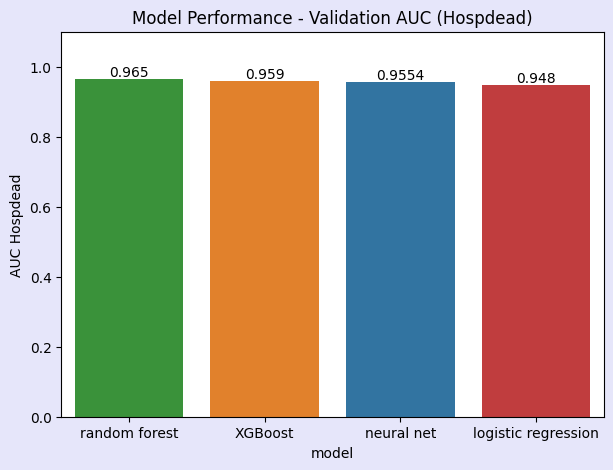

In [286]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(val_hospdead_auc_df,
            x='model',
            y='AUC',
            hue = 'model',
            ax=ax,
            order=val_hospdead_auc_df.sort_values(by='AUC',ascending=False).model,
            palette=color_map
            #hue_order=val_death_auc_df.sort_values(by='AUC',ascending=False).model
            )
title = 'Model Performance - Validation AUC (Hospdead)'
plt.title(title)
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)
ax.set_ylabel('AUC Hospdead')
plt.ylim(0,1.1)
fig.set_facecolor('lavender')
ax.set_aspect('auto')
file_path = plot_folder / title
plt.savefig(str(file_path)+'.png', dpi=1000, bbox_inches='tight')

In [220]:

# top 20 features only (NN data was not pruned)
val_death_auc_pruned = {
    'neural net':0.8371,
    'random forest': 0.842,
    'logistic regression': 0.818,
    'XGBoost': 0.826
}

val_hospdead_auc_pruned = {
    'neural net': 0.9554,
    'random forest': 0.965,
    'logistic regression':0.948,
    'XGBoost': 0.959
}

In [271]:
val_death_auc_pruned_df = pd.DataFrame(val_death_auc_pruned.items(), columns = ['model', 'AUC'])
val_hospdead_auc_pruned_df = pd.DataFrame(val_hospdead_auc_pruned.items(), columns = ['model', 'AUC'])

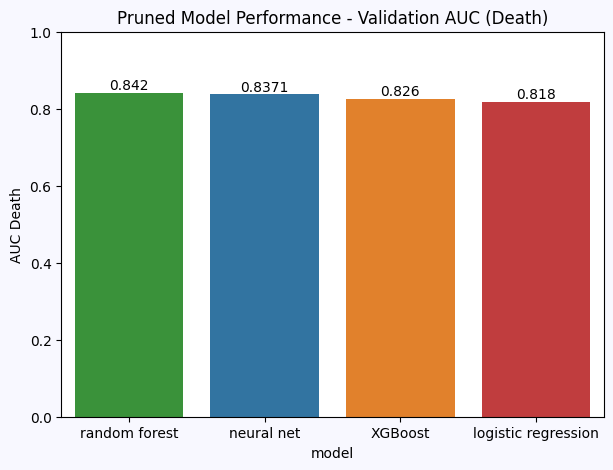

In [277]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(val_death_auc_pruned_df,
            x='model',
            y='AUC',
            hue = 'model',
            ax=ax,
            order=val_death_auc_pruned_df.sort_values(by='AUC',ascending=False).model,
            palette=color_map
            #hue_order=val_death_auc_df.sort_values(by='AUC',ascending=False).model
            )
plt.title('Pruned Model Performance - Validation AUC (Death)')
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)
ax.set_ylabel('AUC Death')
plt.ylim(0,1)
fig.set_facecolor('ghostwhite')
ax.set_aspect('auto')

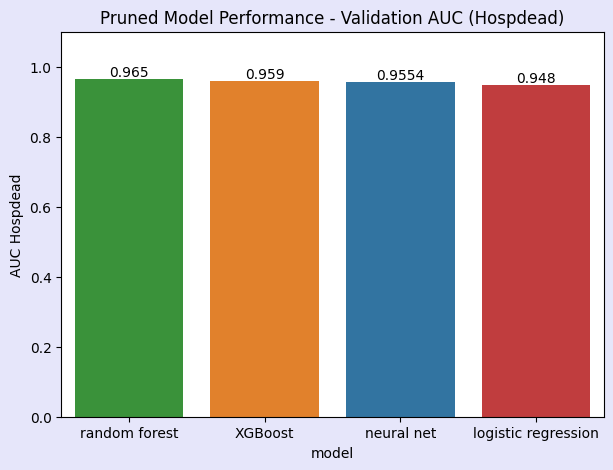

In [278]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(val_hospdead_auc_pruned_df,
            x='model',
            y='AUC',
            hue = 'model',
            ax=ax,
            order=val_hospdead_auc_pruned_df.sort_values(by='AUC',ascending=False).model,
            palette=color_map
            #hue_order=val_death_auc_df.sort_values(by='AUC',ascending=False).model
            )
plt.title('Pruned Model Performance - Validation AUC (Hospdead)')
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)
ax.set_ylabel('AUC Hospdead')
plt.ylim(0,1.1)
fig.set_facecolor('lavender')
ax.set_aspect('auto')

We found the result of feature pruning to have no impact on the AUC score <br>
for the validation training set for hospdead, however performance got slightly<br>
worse for the validation of the death target.

# Conclusion

In this study, Random Forest and XGBoost models demonstrated the strongest overall performance in predicting patient survival and care needs, while Logistic Regression served as a valuable baseline for comparison due to its simplicity and interpretability. Incorporating feature selection techniques and VIF analysis enhanced model transparency and helped reduce multicollinearity, making the results more clinically meaningful.<br>
<br>
For future work, further hyperparameter tuning could help optimize model performance. Additionally, exploring ensemble methods may offer a powerful way to combine the strengths of multiple algorithms, leading to more robust and generalizable predictions.<br>
<br>
This project highlights the transformative business value of integrating AI into healthcare decision-making. By shifting from reactive to predictive care, these models enable early intervention, personalized treatment planning, and more informed decisions around aggressive procedures, ultimately improving outcomes while reducing unnecessary costs. Through rigorous data preparation, we’ve taken steps to reduce bias and promote equitable care.